In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

from gensim.models import KeyedVectors

In [3]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# import numpy as np

In [4]:
drive_path = "/content/drive/MyDrive/Year 4/NLP notebooks and data/dense_vectors"

In [ ]:
# Load pre-trained embeddings
def load_embedding(file_path, embedding_type):
    if embedding_type == "word2vec":
        return KeyedVectors.load_word2vec_format(file_path, binary=True)
    elif embedding_type == "glove":
        # Convert GloVe to Word2Vec format
        glove_vectors = {}
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.array(values[1:], dtype="float32")
                glove_vectors[word] = vector
        return glove_vectors
    elif embedding_type == "fasttext":
        return KeyedVectors.load(file_path)
    else:
        raise ValueError("Unsupported embedding type")

In [ ]:
# Compute sentence embedding by averaging word embeddings
# def get_sentence_embedding(sentence, embedding_model, embedding_dim):
#     words = sentence.split()
#     embeddings = []
#     for word in words:
#         if word in embedding_model:
#             embeddings.append(embedding_model[word])
#     if embeddings:
#         return np.mean(embeddings, axis=0)
#     else:
#         return np.zeros(embedding_dim)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
# df = pd.read_csv('/content/drive/MyDrive/Year 4/NLP notebooks and data/dense_vectors/w2v_sent_added_fasttext.csv')

In [26]:
df_labels = pd.read_csv('/content/drive/MyDrive/Year 4/NLP notebooks and data/Data/Preprocessed/labelled_data.csv', index_col = 0)

In [58]:
# df.shape

(11808, 25)

In [27]:
df_labels.shape

(11808, 30)

In [61]:
# df.columns

Index(['helpfulVotes', 'id', 'address', 'city', 'placeName', 'numberOfReviews',
       'placeRating', 'webUrl', 'publishedDate', 'userRating', 'roomTip',
       'review_text', 'review_title', 'travelDate', 'tripType', 'username',
       'word_tokens', 'bpe_tokens', 'bigram_tokens', 'trigram_tokens',
       'whitespace_tokens', 'rule_based_tokens', 'spacy_tokens',
       'wordpiece_tokens', 'w2v_sent_vectors', 'fasttext_vector'],
      dtype='object')

In [28]:
df_labels.columns

Index(['id', 'address', 'city', 'placeName', 'numberOfReviews', 'placeRating',
       'webUrl', 'publishedDate', 'userRating', 'roomTip', 'review_text',
       'review_title', 'travelDate', 'tripType', 'username', 'word_tokens',
       'bpe_tokens', 'bigram_tokens', 'trigram_tokens', 'whitespace_tokens',
       'rule_based_tokens', 'spacy_tokens', 'wordpiece_tokens', 'vader_score',
       'compound_score', 'vader_category', 'flair_sentiment',
       'flair_confidence', 'textblob_sentiment', 'majority_vote'],
      dtype='object')

In [54]:

# df = df.reset_index(drop=True)


In [62]:
# df.head(2)

,helpfulVotes,id,address,city,placeName,numberOfReviews,placeRating,webUrl,publishedDate,userRating,...,word_tokens,bpe_tokens,bigram_tokens,trigram_tokens,whitespace_tokens,rule_based_tokens,spacy_tokens,wordpiece_tokens,w2v_sent_vectors,fasttext_vector
0,0.0,978474125.0,"24 Dharmapala Mawatha Dharmapala Mawatha, Colo...",Colombo,Nh Collection Colombo,2392,4.5,https://www.tripadvisor.com/Hotel_Review-g2939...,2024-11-03,5.0,...,"['good', 'service', 'ayu', 'friendly', 'staff'...","['good', 'service', 'ayu', 'friendly', 'staff'...","[('good', 'service'), ('service', 'ayu'), ('ay...","[('good', 'service', 'ayu'), ('service', 'ayu'...","['good', 'service', 'ayu', 'friendly', 'staff'...","['good', 'service', 'ayu', 'friendly', 'staff'...","['good', 'service', 'ayu', 'friendly', 'staff'...","['good', 'service', 'ayu', 'friendly', 'staff'...",[ 0.31044984 0.4014417 0.08356439 -0.276954...,[-0.11610988 -0.12987489 -0.33931983 0.087919...
1,0.0,978053018.0,"24 Dharmapala Mawatha Dharmapala Mawatha, Colo...",Colombo,Nh Collection Colombo,2392,4.5,https://www.tripadvisor.com/Hotel_Review-g2939...,2024-10-30,1.0,...,"['change', 'r', 'lady', 'manager', 'r', 'hotel...","['change', 'r', 'lady', 'manager', 'r', 'hotel...","[('change', 'r'), ('r', 'lady'), ('lady', 'man...","[('change', 'r', 'lady'), ('r', 'lady', 'manag...","['change', 'r', 'lady', 'manager', 'r', 'hotel...","['change', 'r', 'lady', 'manager', 'r', 'hotel...","['change', 'r', 'lady', 'manager', 'r', 'hotel...","['change', 'r', 'lady', 'manager', 'r', 'hotel...",[ 0.0217988 0.116291 0.17720811 0.093357...,[-0.23382354 0.18804383 -0.10833292 0.135183...


## Load labels (y)

In [29]:
y = df_labels['majority_vote']

In [41]:
y.shape

(11808,)

In [43]:
y[0].shape

(9550,)

## Load vectors (X)

In [70]:
# Load the NumPy array from the .npy file
vec_type = 'fasttext'
loaded_vectors = np.load(drive_path+f'/{vec_type}_vectors.npy')

In [71]:
loaded_vectors.shape

(11808, 100)

In [72]:
X = loaded_vectors

In [37]:
y.value_counts()

,count
majority_vote,
positive,11227
negative,565
neutral,16


In [74]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Without SMOTE

In [75]:
# Train Random Forest model - Without SMOTE
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
y_pred = rf_model.predict(X_test)

In [77]:
print("Without SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Without SMOTE:
Accuracy: 0.9618966977138018
Confusion Matrix:
 [[  22    0   70]
 [   0    0    4]
 [  16    0 2250]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.58      0.24      0.34        92
     neutral       0.00      0.00      0.00         4
    positive       0.97      0.99      0.98      2266

    accuracy                           0.96      2362
   macro avg       0.52      0.41      0.44      2362
weighted avg       0.95      0.96      0.95      2362



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## With SMOTE

In [78]:
# With SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [79]:
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = rf_model_smote.predict(X_test)

In [80]:
print("\nWith SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_pred_sm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sm))
print("Classification Report:\n", classification_report(y_test, y_pred_sm))


With SMOTE:
Accuracy: 0.9508890770533446
Confusion Matrix:
 [[  62    0   30]
 [   1    0    3]
 [  82    0 2184]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.43      0.67      0.52        92
     neutral       0.00      0.00      0.00         4
    positive       0.99      0.96      0.97      2266

    accuracy                           0.95      2362
   macro avg       0.47      0.55      0.50      2362
weighted avg       0.96      0.95      0.96      2362



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Balanced RF Model

In [81]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(random_state=42)


In [82]:
brf_model.fit(X_train, y_train)
y_pred = brf_model.predict(X_test)

print("With Balanced RF model:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


With Balanced RF model:
Accuracy: 0.8272650296359018
Confusion Matrix:
 [[  56   27    9]
 [   0    3    1]
 [ 181  190 1895]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.24      0.61      0.34        92
     neutral       0.01      0.75      0.03         4
    positive       0.99      0.84      0.91      2266

    accuracy                           0.83      2362
   macro avg       0.41      0.73      0.43      2362
weighted avg       0.96      0.83      0.89      2362



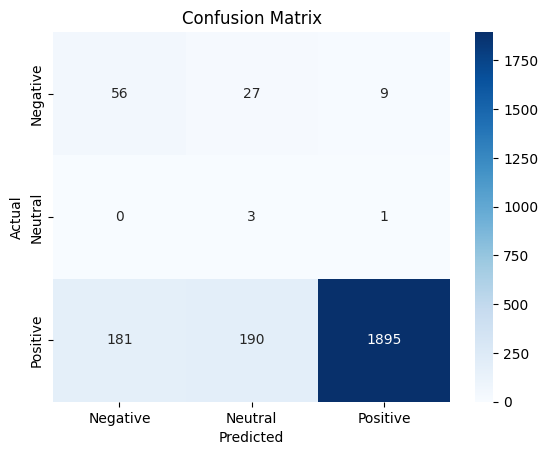

In [83]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

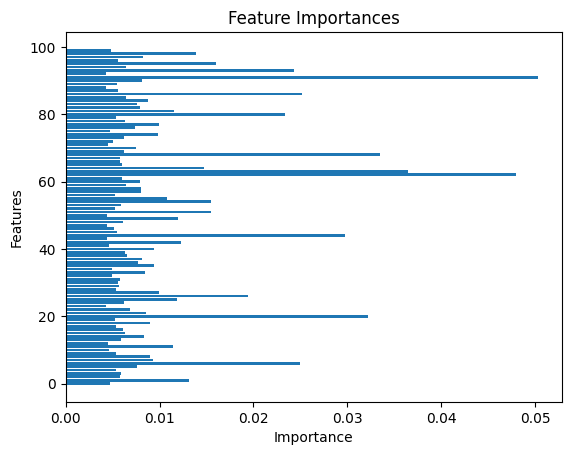

In [84]:
feature_importances = rf_model.feature_importances_
plt.barh(range(len(feature_importances)), feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [87]:
def fit_predict_evaluate(model, X_train, y_train, X_test, y_test, text_print = ""):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(text_print)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


With Balanced Random Forest Model
Accuracy: 0.8272650296359018
Confusion Matrix:
 [[  56   27    9]
 [   0    3    1]
 [ 181  190 1895]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.24      0.61      0.34        92
     neutral       0.01      0.75      0.03         4
    positive       0.99      0.84      0.91      2266

    accuracy                           0.83      2362
   macro avg       0.41      0.73      0.43      2362
weighted avg       0.96      0.83      0.89      2362



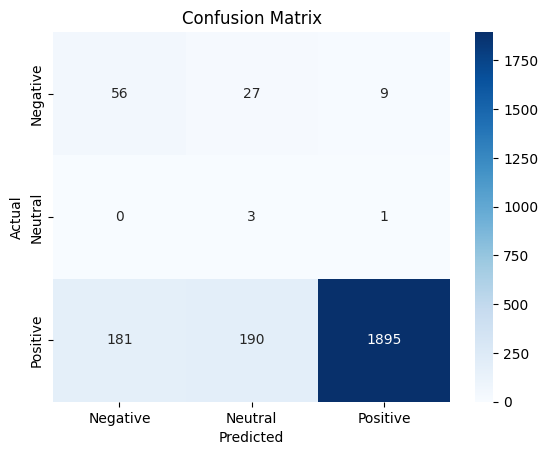

In [88]:
fit_predict_evaluate(model =brf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, text_print = "With Balanced Random Forest Model")

Without SMOTE Random Forest
Accuracy: 0.9618966977138018
Confusion Matrix:
 [[  22    0   70]
 [   0    0    4]
 [  16    0 2250]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.58      0.24      0.34        92
     neutral       0.00      0.00      0.00         4
    positive       0.97      0.99      0.98      2266

    accuracy                           0.96      2362
   macro avg       0.52      0.41      0.44      2362
weighted avg       0.95      0.96      0.95      2362



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


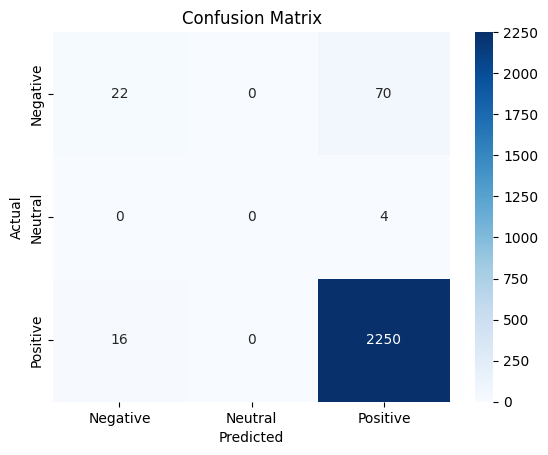

In [90]:
fit_predict_evaluate(model =rf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, text_print = "Without SMOTE Random Forest")